# Do the hello world example on a 2-qubit state 

## Step 1: Map the problem to circuits and operators

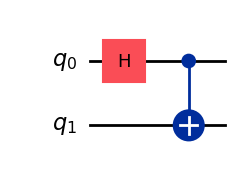

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)

qc.draw(output='mpl')

In [3]:
from qiskit.quantum_info import Pauli

zz = Pauli('ZZ')
zi = Pauli('ZI')
iz = Pauli('IZ')
xx = Pauli('XX')
xi = Pauli('XI')
ix = Pauli('IX')

observables = [zz, zi, iz, xx, xi, ix]




# Step 2 : Optimize 

## Step 3 : Execute on the backend

In [4]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job=estimator.run([qc]*len(observables), observables)

job.result()

EstimatorResult(values=array([1.        , 0.01757812, 0.01757812, 1.        , 0.0234375 ,
       0.0234375 ]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'time_taken': 0.002398683, 'num_bind_params': 1, 'parallel_state_update': 12, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000319862, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 15311, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9996910095214844, 'simulator_metadata': [{'time_taken': 0.002398683, 'num_bind_params': 1, 'parallel_state_update': 12, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000319

## Step 4: Post-process(and plotting)

Text(0, 0.5, 'expectation value')

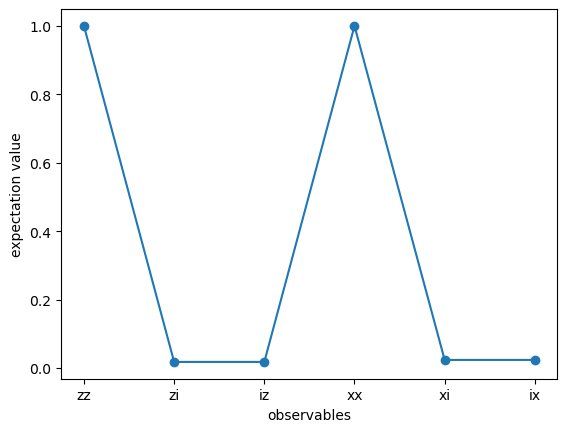

In [5]:
import matplotlib.pyplot as plt

data = ['zz', 'zi', 'iz', 'xx', 'xi', 'ix']
values = job.result().values
plt.plot(data, values, '-o' )
plt.xlabel('observables')
plt.ylabel('expectation value')


# Extend the Hello world example to an $n$-qubit GHZ state

# Step 1 : Map the problem to circuits and operators

In [6]:
def get_qc_for_n_qubit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i,i+1)
    return qc

n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)


In [7]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range (n-1)]
print(operator_strings)
print(len(operator_strings))

operators=[SparsePauliOp(operator_string) for operator_string in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 2: Optimize the problem for quantum execution

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().get_backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]


## Step 3: Execute on the backend

In [14]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1 
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)
job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)


crraz85x484g008ezc7g


## Step 4: Post-process and plot

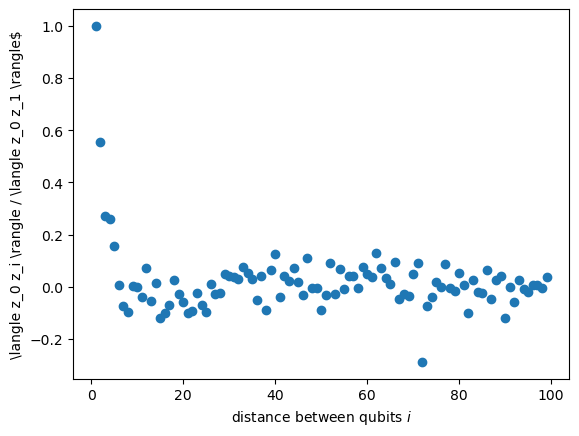

In [18]:
import matplotlib.pyplot as plt
job_id= 'crr24d9xg040008petq0'

service = QiskitRuntimeService()
job = service.job(job_id)

data = list(range(1,len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v/values[0]for v in values]
plt.scatter(data, values, marker='o', label= str(n)+'-qubits GHZ state')
plt.xlabel('distance between qubits $i$')
plt.ylabel(r'\langle z_0 z_i \rangle / \langle z_0 z_1 \rangle$')
plt.show()